# Лаба 2

**Дедлайн**: 25 ноября

**Задача**: написать определитель тональности текста (сообщениея в Twitter) c помощью fine-tuning-а на датасете RuSentiTweet (https://github.com/sismetanin/rusentitweet)

На что обратить внимание:
* (+)Подготовка данных (очистка, токенизация и упаковка датасета в удобный класс) - у вас в задании другой датасет, соответственно обработка может поменяться. В датасете несколько файлов, скачайте rusentitweet_full.csv и работайте с ним
* (+)Процедура дообучения. Вам необходимо доработать имеющуюся процедуру:
    * (+-) Добавить графики качества обучения модели в зависимости от шага (делать валидацию каждые 100 шагов (например), а не раз в эпоху)
    * (+) Замерить время обучения
    * (-) Добавить больше метрик для отслеживания (изучите по открытым источникам, какие метрики используются для задачи определения тональности и почему)
        * ![](./images/img_1.png)
    * (+) Добавить заморозку части слоев (все, кроме слоя классификации, или кроме слоя классификации + 2-3 последних слоев с интентами)
    * (+-) Подобрать количество эпох, размер батча и заморозку так, чтобы модель давала лучший результат
* (+)Модель для дообучения (попробуйте как минимум 2 разных модели), искать подходящие модели можно с помощью гугла и https://huggingface.co/
* (+)Результаты **всех** экспериментов должны быть описаны в отдельной ячейке
* (+)Inference модели - обученную модель нужно обернуть в удобную функцию для использования, которая по тексту будет возвращать его тональность


https://www.youtube.com/watch?v=xI0HHN5XKDo

## Импорты

In [1]:
import typing, re, torch, os.path, sys, emot, torchmetrics, functools, gc

from torch.utils.data.dataset import T_co

# костыль, чтоб общий файлик сгрузить
if not sys.path.__contains__('..'):
    sys.path.insert(0, '..')
import helper

from num2words import num2words
from cleantext import clean
from pathlib import Path

from torch.utils.data import TensorDataset, DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import compute_class_weight

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

emot_core = emot.core.emot()

In [ ]:
import importlib

importlib.reload(helper)

## Константы

In [3]:
SEED = 42
BATCH_SIZE = 32
SPLIT_SIZE = 0.3
NUM_WORKERS = 4
device = "cuda" if torch.cuda.is_available() else "cpu"

## Очистка данных

Разберемся с данными - уберем ненужные колонки, символы и т.д.

In [4]:
# Как всегда - на все случаи жизни есть библиотечки.
# Однако зачем-то я решил настолько очисткой заморочиться, что даже эмотиконы вытащил, и вот на это библиотек не было

def num2words_with_extract(text: typing.AnyStr) -> typing.AnyStr:
    split_text = text.split(' ')
    for idx, segment in enumerate(split_text):
        if segment.isdigit():
            split_text[idx] = num2words(segment, lang='ru')
    return " ".join(split_text)


def remove_emoticons(text: typing.AnyStr, emot_core) -> typing.AnyStr:  # TODO: write your own emoticon regexp
    res = emot_core.emoticons(text)
    for emoticon in res['value']:
        # print(emoticon)
        regex = '(?:'
        for symbol in [*emoticon]:
            regex += (symbol if symbol.isalpha() or symbol.isdigit() else '\\' + symbol) + '+'
        regex += ')'
        # print(regex)
        compiled = re.compile(regex)
        text = compiled.sub(r'', text)
    return text


def clean_text(text: typing.AnyStr, emot_core=emot_core) -> typing.AnyStr:
    text = clean(
        text=text,
        fix_unicode=False,  # fix various unicode errors
        to_ascii=False,  # transliterate to closest ASCII representation
        lower=True,  # lowercase text
        no_line_breaks=True,  # fully strip line breaks as opposed to only normalizing them
        no_urls=True,  # replace all URLs with a special token
        no_emails=True,  # replace all email addresses with a special token
        no_phone_numbers=True,  # replace all phone numbers with a special token
        no_emoji=True,
        no_numbers=False,  # replace all numbers with a special token
        no_digits=False,  # replace all digits with a special token
        no_currency_symbols=False,  # replace all currency symbols with a special token
        no_punct=False,  # remove punctuations
        normalize_whitespace=True,
        replace_with_punct="",  # instead of removing punctuations you may replace them
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="",
        replace_with_currency_symbol="",
        # lang="en"                       # set to 'de' for German special handling
    )
    tag_pattern = re.compile("@\S+")
    dot_pattern = re.compile("\.{2,}")
    text = tag_pattern.sub(r'', text)  # убираем теги юзеров
    text = dot_pattern.sub(r'', text)  # убираем многоточия (на всякий случай, тк их много)
    text = remove_emoticons(text, emot_core)  # убираем эмотиконы типа :) :-(((
    text = num2words_with_extract(text)  # преобразуем цифры в текст
    return " ".join(text.split())  # normalize whitespaces


# пример отработки
clean_text(
    "@varlamov @McFa__ul bortnikov@mail.ru На Ой какие неожиданные ::-( :333 100 .......... результаты 🤭 https://t.co/ZwOHPDKUqq 88005553535",
    emot_core)

'на ой какие неожиданные сто результаты'

In [5]:
twitter_cut = None
csv_path = Path("csv")
twitter_full_path = csv_path / "twitter_full.csv"
twitter_cut_path = csv_path / "twitter_cut.pickle"

twitter = pd.read_csv(twitter_full_path)

if not os.path.exists(twitter_cut_path):
    print("Clearing initial csv and saving to pickle")
    twitter_cut = twitter.drop(["id", "Unnamed: 0"], inplace=False, axis=1)  # .rename(columns={"Unnamed: 0": "index"})
    twitter_cut = twitter_cut[twitter_cut["label"] != "skip"]
    twitter_cut = twitter_cut.reset_index()
    twitter_cut.rename(columns={"index": "old_idx"}, inplace=True)
    twitter_cut["text_clean"] = twitter_cut["text"].apply(clean_text)
    twitter_cut.to_pickle(twitter_cut_path)
else:
    print("Loading existing pickle")
    twitter_cut = pd.read_pickle("./csv/twitter_cut.pickle")


Loading existing pickle


In [6]:
# twitter.head(10)

In [7]:
twitter_cut.head(100)

,old_idx,text,label,text_clean
0,1,велл они всё равно что мусор так что ничего с...,negative,велл они всё равно что мусор так что ничего ст...
1,2,"""трезвая жизнь какая-то такая стрёмная""\r\n(с)...",negative,"""трезвая жизнь какая-то такая стрёмная"" (с) ар..."
2,3,Ой какие неожиданные результаты 🤭 https://t.co...,neutral,ой какие неожиданные результаты
3,4,@Shvonder_chief @dimsmirnov175 На заборе тоже ...,neutral,"на заборе тоже написано,а там другое.о сборе д..."
4,5,@idkwhht мы тоже мебельная компания уджина😳😳😳,neutral,мы тоже мебельная компания уджина
...,...,...,...,...
95,110,@snakey_ssnake Делать еще ╰(‵□′)╯ (мне понрави...,positive,делать еще ╰(‵□′)╯ (мне понравилось)
96,112,@cerealporridge 😭😭😭😭♥️♥️♥️♥️ спасибо 😭♥️♥️♥️♥️,speech,спасибо
97,114,В СевГУ прошел круглый стол по случаю Дня соли...,neutral,в севгу прошел круглый стол по случаю дня соли...
98,115,"@great_knee Бро,моя тоже",neutral,"бро,моя тоже"


In [8]:
def label_to_int(label):
    if label == 'negative':
        return 0
    elif label == 'neutral' or label == 'speech':
        return 1
    elif label == 'positive':
        return 2


twitter_cut["num_label"] = twitter_cut["label"].apply(label_to_int)

twitter_cut

,old_idx,text,label,text_clean,num_label
0,1,велл они всё равно что мусор так что ничего с...,negative,велл они всё равно что мусор так что ничего ст...,0
1,2,"""трезвая жизнь какая-то такая стрёмная""\r\n(с)...",negative,"""трезвая жизнь какая-то такая стрёмная"" (с) ар...",0
2,3,Ой какие неожиданные результаты 🤭 https://t.co...,neutral,ой какие неожиданные результаты,1
3,4,@Shvonder_chief @dimsmirnov175 На заборе тоже ...,neutral,"на заборе тоже написано,а там другое.о сборе д...",1
4,5,@idkwhht мы тоже мебельная компания уджина😳😳😳,neutral,мы тоже мебельная компания уджина,1
...,...,...,...,...,...
11544,13386,Это просто промокод и он одноразовый! https://...,neutral,это просто промокод и он одноразовый!,1
11545,13387,все пора спать пиздец словила шизу,negative,все пора спать пиздец словила шизу,0
11546,13388,такими темпами я создам новую секту или органи...,neutral,такими темпами я создам новую секту или органи...,1
11547,13389,"Ты смотрела аниме, завернувшись в одеяло ,пока...",neutral,"ты смотрела аниме, завернувшись в одеяло ,пока...",1


[Text(0, 0, 'neg'), Text(1, 0, 'neu'), Text(2, 0, 'pos')]

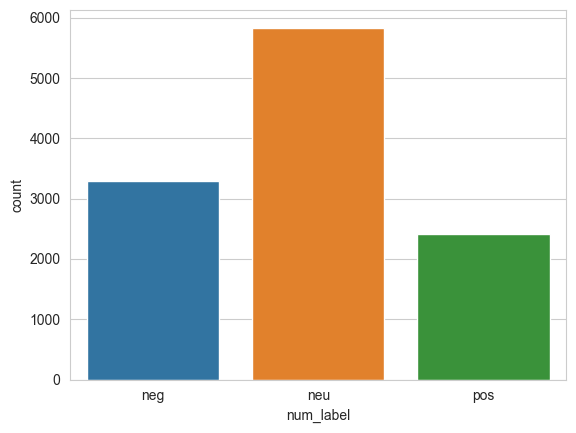

In [9]:
ax = sns.countplot(data=twitter_cut, x="num_label")
ax.set_xticklabels(["neg", "neu", "pos"])

Из-за того, что speech ушел в neutral, то у нас возникает дисбаланс (возможно с этим стоило что-то сделать)

## Высокоуровневая предобработка

Сначала попробуем дистиллированную модель https://habr.com/ru/articles/562064/

In [10]:
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path="cointegrated/rubert-tiny")

In [11]:
def tokenize_tiny(text):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=64,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    return pd.Series([encoding["input_ids"], encoding["attention_mask"]])

Вроде как можно написать кастомный класс датасета, но вроде как можно и не писать, так и не понял пока

In [12]:
twitter_cut_tiny = twitter_cut.copy()
twitter_cut_tiny[["input_ids", "attention_mask"]] = twitter_cut_tiny["text_clean"].apply(tokenize_tiny)

Разделяем на трейн/тест

In [13]:
train_df, test_df = train_test_split(
    twitter_cut_tiny,
    test_size=SPLIT_SIZE,
    shuffle=True,
    stratify=twitter_cut_tiny['num_label'].values,
    random_state=SEED
)

train_dataset, test_dataset, train_dataloader, test_dataloader = helper.prepare_ds_dl_transformer(
    train_dataframe=train_df,
    test_dataframe=test_df,
    label_field_name="num_label",
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

## Кидаем все это в модель

In [14]:
f1 = torchmetrics.F1Score(
    task="multiclass",
    num_classes=3,
    device=device
).to(device)

In [15]:
# Заметка для себя - параметры тут https://huggingface.co/transformers/v2.9.1/main_classes/configuration.html

def rubert_tiny_trainer(
        epochs: int,
        lr: float,
        file_name: typing.AnyStr,
        force_override: bool,
        scheduler_gamma: float or None = None,
        model: BertForSequenceClassification = None,
):
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)

    rubert = None
    if model is None:
        rubert = BertForSequenceClassification.from_pretrained(
            pretrained_model_name_or_path="cointegrated/rubert-tiny",
            num_labels=3,
            output_attentions=False,
            output_hidden_states=False,
        )
    else:
        rubert = model

    rubert.to(device)
    rubert.name = file_name

    rubert_optimizer = torch.optim.AdamW(
        rubert.parameters(),
        lr=lr,
    )
    scheduler = None
    if scheduler_gamma is not None:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer=rubert_optimizer,
            gamma=scheduler_gamma,
            verbose=True
        )

    return helper.model_trainer_with_saving(
        model=rubert,
        epochs=epochs,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        loss_function=None,
        optimizer=rubert_optimizer,
        eval_function=f1,
        device=device,
        file_name=file_name,
        scheduler=scheduler,
        transformer=True,
        force_override=force_override,
        models_folder='models',
        res_folder='model_res'
    )


class_names = ["negative", "neutral", "positive"]


def tiny_results_show(model, results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    helper.model_eval_report(
        model=model,
        test_dataloader=test_dataloader,
        test_dataset=test_dataset,
        loss_function=None,
        eval_function=f1,
        device=device,
        transformer=True,
        class_names=class_names
    )
    # plt.rcParams['figure.figsize'] = [6, 5]
    ax1.plot(results.history_test_loss[0], label='test_loss')
    ax1.plot(results.history_train_loss[0], label='train_loss')
    ax1.set_title('loss')
    ax1.legend()
    # plt.rcParams['figure.figsize'] = [6, 5]
    ax2.plot(results.history_test_eval[0], label='test_eval')
    ax2.plot(results.history_train_eval[0], label='train_eval')
    ax2.set_title('eval')
    ax2.legend()


In [16]:
rubert_tiny1, rubert_tiny_results1 = rubert_tiny_trainer(
    epochs=15,
    lr=3e-5,
    force_override=False,
    file_name="rubert_tiny_ep15_lr3e-5"
)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Loading existing model


Как можно заметить - самому добавлять слои не пришлось, на выходе 3 фичи

Наблюдаем очевиднейший оверфит?... Попробую уменьшить скорость обучения

In [ ]:
tiny_results_show(
    rubert_tiny1,
    rubert_tiny_results1
)

In [18]:
rubert_tiny2, rubert_tiny_results2 = rubert_tiny_trainer(
    epochs=15,
    lr=3e-6,
    force_override=False,
    file_name="rubert_tiny_ep15_lr3e-6"
)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Loading existing model


In [ ]:
tiny_results_show(
    rubert_tiny2,
    rubert_tiny_results2
)

Получше, но все равно глохнет на 65%, попробую расписание добавить

In [20]:
rubert_tiny3, rubert_tiny_results3 = rubert_tiny_trainer(
    epochs=15,
    lr=3e-5,
    scheduler_gamma=0.5,
    force_override=False,
    file_name="rubert_tiny_ep15_lr3e-5_gamma50"
)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Adjusting learning rate of group 0 to 3.0000e-05.
Loading existing model


Результаты лучше, но гамма будто большая, гасится раньше положенного

In [ ]:
tiny_results_show(
    rubert_tiny3,
    rubert_tiny_results3
)

In [87]:
rubert_tiny4, rubert_tiny_results4 = rubert_tiny_trainer(
    epochs=15,
    lr=3e-5,
    scheduler_gamma=0.75,
    force_override=False,
    file_name="rubert_tiny_ep15_lr3e-5_gamma75"
)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Adjusting learning rate of group 0 to 3.0000e-05.
Loading existing model


In [ ]:
tiny_results_show(
    rubert_tiny4,
    rubert_tiny_results4
)

Примерно то же самое, но лосс на тесте рос, поэтому 0.5 гаммы было оптимально видимо

#### Check overfit

In [24]:
rubert_tiny_OF, rubert_tiny_results_OF = rubert_tiny_trainer(
    epochs=50,
    lr=5e-6,
    force_override=False,
    file_name="rubert_tiny_ep50_lr5e-6_OVERFIT_TEST"
)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Loading existing model


In [ ]:
tiny_results_show(
    rubert_tiny_OF,
    rubert_tiny_results_OF
)

## Double descend

В общем на лекции нам расказали про эффект двойного спуска, меня это заинтересовало, прочитал оригинальную бумагу и решил проверить. Кинул на 5000 эпох, оставил коптиться на ~6 часов, в итоге компьютер скис с блускрином на 3000 эпохе. Поведения двойного спуска не было, тестлосс продолжал рости и никак не хотел разворачиваться обратно. Скорее всего, потому что дистилированная модель не оверпараметризованная и нужно брать берт/бертлардж для наблюдения эффекта. В сторону именно берта не копал, но по изначальной статье эффект должен наблюдаться и у трансформеров.

In [26]:
# rubert_tiny, rubert_tiny_results = rubert_tiny_trainer(
#     epochs=5000,
#     lr=3e-6,
#     force_override=False,
#     file_name="rubert_tiny_ep5000_lr3e-6"
# )

In [27]:
# rubert_tiny_results_show(
#     rubert_tiny,
#     rubert_tiny_results
# )

составим табличку результатов по rubert_tiny

In [28]:
rubert_tiny_all = pd.concat([rubert_tiny_results1, rubert_tiny_results2, rubert_tiny_results3, rubert_tiny_results4])
rubert_tiny_all

,name,class_name,status,epochs_remain,on_which_batch_broken,train_time,loss_function,optimizer,learning_rate,eval_function,device,end_test_loss,end_test_eval,end_train_loss,end_train_eval,history_test_loss,history_test_eval,history_train_loss,history_train_eval
0,rubert_tiny_ep15_lr3e-5,BertForSequenceClassification,TrainStatus.Success,0,None,84.419073,NoneType,AdamW,3.000000e-05,MulticlassF1Score,cuda,1.498644,0.648159,0.122758,0.959536,"[0.81073, 0.77603, 0.7722, 0.78766, 0.82281, 0...","[0.63781, 0.65775, 0.66922, 0.6718, 0.67094, 0...","[0.92728, 0.76131, 0.68418, 0.61027, 0.54613, ...","[0.56902, 0.67354, 0.71821, 0.75472, 0.79079, ..."
0,rubert_tiny_ep15_lr3e-6,BertForSequenceClassification,TrainStatus.Success,0,None,80.687391,NoneType,AdamW,3.000000e-06,MulticlassF1Score,cuda,0.787649,0.645993,0.719137,0.695405,"[1.02799, 0.99297, 0.96351, 0.92789, 0.89032, ...","[0.50707, 0.52039, 0.53832, 0.55995, 0.59566, ...","[1.06019, 1.00558, 0.97351, 0.93928, 0.90197, ...","[0.48434, 0.51294, 0.54049, 0.5626, 0.58841, 0..."
0,rubert_tiny_ep15_lr3e-5_gamma50,BertForSequenceClassification,TrainStatus.Success,0,None,80.672499,NoneType,AdamW,9.155273e-10,MulticlassF1Score,cuda,0.778388,0.659627,0.676965,0.719121,"[0.81073, 0.78908, 0.78093, 0.7806, 0.78153, 0...","[0.63781, 0.64628, 0.64886, 0.65259, 0.65431, ...","[0.92728, 0.76537, 0.72155, 0.69749, 0.69167, ...","[0.56902, 0.67488, 0.69669, 0.70413, 0.71104, ..."
0,rubert_tiny_ep15_lr3e-5_gamma75,BertForSequenceClassification,TrainStatus.Success,0,None,81.819096,NoneType,AdamW,4.009038e-07,MulticlassF1Score,cuda,0.810899,0.666794,0.528303,0.798641,"[0.81073, 0.78125, 0.77734, 0.77857, 0.7876, 0...","[0.63781, 0.64985, 0.65889, 0.66724, 0.66609, ...","[0.92728, 0.7626, 0.70039, 0.65345, 0.62534, 0...","[0.56902, 0.67421, 0.70677, 0.72994, 0.74978, ..."


## Rubert-tiny freeze

Попробую заморозить все слои, кроме классифицирующего слоя

Посмотрим слои модели

In [29]:
rubert_tiny_freeze1 = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="cointegrated/rubert-tiny",
    num_labels=3
).to(device)

rubert_tiny_freeze1

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, e

Оставляем только classifier

In [30]:
for name, param in rubert_tiny_freeze1.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

In [31]:
rubert_tiny_freeze1, rubert_tiny_freeze1_results = rubert_tiny_trainer(
    epochs=30,
    lr=3e-3,
    scheduler_gamma=0.75,
    force_override=False,
    file_name="rubert_tiny_freeze_cls_ep15_lr3e-3_gamma75",
    model=rubert_tiny_freeze1
)

Adjusting learning rate of group 0 to 3.0000e-03.
Loading existing model


Получилось хуже, чем без заморозки, но лучше, чем без фриза и с маленьким lr. Посмотрим что на графиках.

In [ ]:
tiny_results_show(
    rubert_tiny_freeze1,
    rubert_tiny_freeze1_results
)

Попробую заморозить только эмбединги

In [33]:
rubert_tiny_freeze2 = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="cointegrated/rubert-tiny",
    num_labels=3
).to(device)
for name, param in rubert_tiny_freeze2.named_parameters():
    if "embeddings" not in name and "classifier" not in name:
        param.requires_grad = False
rubert_tiny_freeze2, rubert_tiny_freeze2_results = rubert_tiny_trainer(
    epochs=30,
    lr=8e-4,
    scheduler_gamma=0.75,
    force_override=False,
    file_name="rubert_tiny_freeze_emb_cls_ep15_lr8e-4_gamma75",
    model=rubert_tiny_freeze2
)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Adjusting learning rate of group 0 to 8.0000e-04.
Loading existing model


In [ ]:
tiny_results_show(
    rubert_tiny_freeze2,
    rubert_tiny_freeze2_results
)

Интерпретировать могу только так - хватило первого эпохи на дообучение, потом модель пошла на переобучение. Попробую теперь вместо эмбедингов заморозить энкодер.

In [35]:
rubert_tiny_freeze3 = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="cointegrated/rubert-tiny",
    num_labels=3
).to(device)
for name, param in rubert_tiny_freeze3.named_parameters():
    if "encoder" in name or "classifier" in name:
        param.requires_grad = False
rubert_tiny_freeze3, rubert_tiny_freeze3_results = rubert_tiny_trainer(
    epochs=30,
    lr=1e-5,
    # scheduler_gamma=0.75,
    force_override=False,
    file_name="rubert_tiny_freeze_enc_cls_ep15_lr1e-5",
    model=rubert_tiny_freeze3
)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

Loading existing model


In [ ]:
tiny_results_show(
    rubert_tiny_freeze3,
    rubert_tiny_freeze3_results
)

Лучший результат - 66-67% f1, то есть все же идеальный результат был при разморозке всех слоёв. На этом с дистилированной моделью можно закончить и перейти к полноразмерной rubert, которая основана на bert-base.

In [37]:
# У меня где-то течет память на видеокарте, и это даже не помогает особо(( Возможно модели остаются на видюхе и не хотят уходить, потому что где-то еще висит референс на них

del rubert_tiny1
del rubert_tiny2
del rubert_tiny3
del rubert_tiny4
del rubert_tiny_freeze1
del rubert_tiny_freeze2
del rubert_tiny_freeze3
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

## Rubert-base

In [38]:
tokenizer_base = BertTokenizer.from_pretrained(pretrained_model_name_or_path="blanchefort/rubert-base-cased-sentiment")
twitter_cut_base = twitter_cut.copy()


def tokenize_base(text):
    encoding = tokenizer_base.encode_plus(
        text,
        add_special_tokens=True,
        max_length=64,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )
    return pd.Series([encoding["input_ids"], encoding["attention_mask"]])


twitter_cut_base[["input_ids", "attention_mask"]] = twitter_cut_base["text_clean"].apply(tokenize_base)

train_df_base, test_df_base = train_test_split(
    twitter_cut_base,
    test_size=SPLIT_SIZE,
    shuffle=True,
    stratify=twitter_cut_base['num_label'].values,
    random_state=SEED
)

train_dataset_base, test_dataset_base, train_dataloader_base, test_dataloader_base = helper.prepare_ds_dl_transformer(
    train_dataframe=train_df_base,
    test_dataframe=test_df_base,
    label_field_name="num_label",
    batch_size=16,  # Поменьше чтоб память не так быстро улетала (хз поможет ли вообще)
    num_workers=NUM_WORKERS
)
twitter_cut_base.head(10)

,old_idx,text,label,text_clean,num_label,input_ids,attention_mask
0,1,велл они всё равно что мусор так что ничего с...,negative,велл они всё равно что мусор так что ничего ст...,0,"[[tensor(101), tensor(12044), tensor(343), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
1,2,"""трезвая жизнь какая-то такая стрёмная""\r\n(с)...",negative,"""трезвая жизнь какая-то такая стрёмная"" (с) ар...",0,"[[tensor(101), tensor(108), tensor(67121), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
2,3,Ой какие неожиданные результаты 🤭 https://t.co...,neutral,ой какие неожиданные результаты,1,"[[tensor(101), tensor(7537), tensor(1976), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
3,4,@Shvonder_chief @dimsmirnov175 На заборе тоже ...,neutral,"на заборе тоже написано,а там другое.о сборе д...",1,"[[tensor(101), tensor(801), tensor(57939), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
4,5,@idkwhht мы тоже мебельная компания уджина😳😳😳,neutral,мы тоже мебельная компания уджина,1,"[[tensor(101), tensor(995), tensor(1187), tens...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
5,6,Счастья здоровья 10 классникам https://t.co/M9...,speech,счастья здоровья десять классникам,1,"[[tensor(101), tensor(14053), tensor(9165), te...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
6,7,@dntbliev НЕ ПАЛИ.,neutral,не пали.,1,"[[tensor(101), tensor(802), tensor(41952), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
7,8,@BTS_twt ты такой красивый 😭😭😭🥺💓,positive,ты такой красивый,2,"[[tensor(101), tensor(1006), tensor(1447), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
8,9,"@Ladyzchensk Цыган , хуле ...",negative,"цыган , хуле",0,"[[tensor(101), tensor(30607), tensor(128), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
9,10,@nikogdanahui1 С днём рождения 🥳 \r\nУспехов и...,speech,с днём рождения успехов и побед тебе,1,"[[tensor(101), tensor(336), tensor(20106), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [39]:
twitter_cut_tiny.head(10)

,old_idx,text,label,text_clean,num_label,input_ids,attention_mask
0,1,велл они всё равно что мусор так что ничего с...,negative,велл они всё равно что мусор так что ничего ст...,0,"[[tensor(2), tensor(314), tensor(2663), tensor...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
1,2,"""трезвая жизнь какая-то такая стрёмная""\r\n(с)...",negative,"""трезвая жизнь какая-то такая стрёмная"" (с) ар...",0,"[[tensor(2), tensor(6), tensor(330), tensor(27...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
2,3,Ой какие неожиданные результаты 🤭 https://t.co...,neutral,ой какие неожиданные результаты,1,"[[tensor(2), tensor(23983), tensor(1150), tens...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
3,4,@Shvonder_chief @dimsmirnov175 На заборе тоже ...,neutral,"на заборе тоже написано,а там другое.о сборе д...",1,"[[tensor(2), tensor(548), tensor(650), tensor(...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
4,5,@idkwhht мы тоже мебельная компания уджина😳😳😳,neutral,мы тоже мебельная компания уджина,1,"[[tensor(2), tensor(11521), tensor(19091), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
5,6,Счастья здоровья 10 классникам https://t.co/M9...,speech,счастья здоровья десять классникам,1,"[[tensor(2), tensor(329), tensor(14335), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
6,7,@dntbliev НЕ ПАЛИ.,neutral,не пали.,1,"[[tensor(2), tensor(769), tensor(2189), tensor...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
7,8,@BTS_twt ты такой красивый 😭😭😭🥺💓,positive,ты такой красивый,2,"[[tensor(2), tensor(23101), tensor(14050), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
8,9,"@Ladyzchensk Цыган , хуле ...",negative,"цыган , хуле",0,"[[tensor(2), tensor(334), tensor(10330), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
9,10,@nikogdanahui1 С днём рождения 🥳 \r\nУспехов и...,speech,с днём рождения успехов и побед тебе,1,"[[tensor(2), tensor(329), tensor(316), tensor(...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


Судя по всему там одинаковый токенайзер под капотом

Поменяем датасеты и дефолтную модель в предыдущей функции тренера и результатов

In [40]:
def rubert_base_trainer(
        epochs: int,
        lr: float,
        file_name: typing.AnyStr,
        force_override: bool,
        scheduler_gamma: float or None = None,
        model: BertForSequenceClassification = None,
        loss_fn=None
):
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)

    rubert = None
    if model is None:
        rubert = BertForSequenceClassification.from_pretrained(
            pretrained_model_name_or_path="blanchefort/rubert-base-cased-sentiment",
            num_labels=3,
            return_dict=True,
            output_attentions=False,
            output_hidden_states=False
        )
    else:
        rubert = model

    rubert.to(device)

    rubert.name = file_name

    rubert_optimizer = torch.optim.AdamW(
        rubert.parameters(),
        lr=lr,
    )
    scheduler = None
    if scheduler_gamma is not None:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer=rubert_optimizer,
            gamma=scheduler_gamma,
            verbose=True
        )

    return helper.model_trainer_with_saving(
        model=rubert,
        epochs=epochs,
        train_dataloader=train_dataloader_base,
        test_dataloader=test_dataloader_base,
        loss_function=loss_fn,
        optimizer=rubert_optimizer,
        eval_function=f1,
        device=device,
        file_name=file_name,
        scheduler=scheduler,
        transformer=True,
        force_override=force_override,
        models_folder='models',
        res_folder='model_res'
    )


def bert_cls_results_show(model, results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    helper.model_eval_report(
        model=model,
        test_dataloader=test_dataloader_base,
        test_dataset=test_dataset_base,
        loss_function=None,
        eval_function=f1,
        device=device,
        transformer=True,
        class_names=class_names
    )
    # plt.rcParams['figure.figsize'] = [6, 5]
    ax1.plot(results.history_test_loss[0], label='test_loss')
    ax1.plot(results.history_train_loss[0], label='train_loss')
    ax1.set_title('loss')
    ax1.legend()
    # plt.rcParams['figure.figsize'] = [6, 5]
    ax2.plot(results.history_test_eval[0], label='test_eval')
    ax2.plot(results.history_train_eval[0], label='train_eval')
    ax2.set_title('eval')
    ax2.legend()


In [41]:
def print_model_layers(model):
    # Get all of the model's parameters as a list of tuples.
    params = list(model.named_parameters())

    print('The BERT model has {:} different named parameters.\n'.format(len(params)))

    print('==== Embedding Layer ====\n')

    for p in params[0:5]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

    print('\n==== First Transformer ====\n')

    for p in params[5:21]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

    print('\n==== Output Layer ====\n')

    for p in params[-4:]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [42]:
# rubert_base_freeze1 = BertForSequenceClassification.from_pretrained(
#     pretrained_model_name_or_path="blanchefort/rubert-base-cased-sentiment",
#     num_labels=3
# ).to(device)

# for name, param in rubert_base_freeze1.named_parameters():
#     if "classifier" not in name:
#         param.requires_grad = False

rubert_base1, rubert_base1_results = rubert_base_trainer(
    epochs=4,
    lr=2e-5,
    force_override=False,
    file_name="rubert_base_ep4_lr2e-5"
)  # значения по рекомендациям из статьи дообучения берта

Loading existing model


In [ ]:
bert_cls_results_show(
    rubert_base1,
    rubert_base1_results
)

Значения лучше, возможно стоит попробовать еще больше эпох и расписание накинуть

In [44]:
torch.cuda.empty_cache()
gc.collect()
del rubert_base1
gc.collect()

0

In [85]:
rubert_base2, rubert_base2_results = rubert_base_trainer(
    epochs=10,
    lr=3e-5,
    scheduler_gamma=0.90,
    force_override=False,
    file_name="rubert_base_ep10_lr3e-5_gamma90"
)

Adjusting learning rate of group 0 to 3.0000e-05.
Loading existing model


In [ ]:
bert_cls_results_show(
    rubert_base2,
    rubert_base2_results
)

Преодолел порог в 66%, но результаты все равно очень слабые для такой модели. Начинаю подозревать, что проблема в данных, а не в модели, то что neutral дизбалансирует модель и она не может нормально обучиться. Попробую сделать балансировку классов и повторно обучить rubert-base с предыдущими параметрами.

In [47]:
torch.cuda.empty_cache()
gc.collect()
del rubert_base2
gc.collect()

0

## Balancing

Попробую самый тупой подход без class weighting - убрать половину всех neutral данных

[Text(0, 0, 'neg'), Text(1, 0, 'neu'), Text(2, 0, 'pos')]

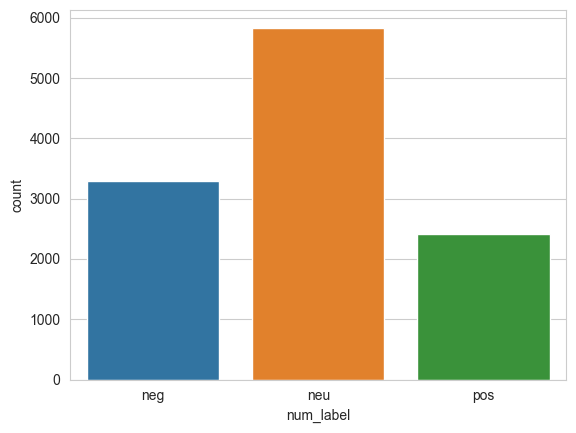

In [48]:
# Вспоминаем какое сейчас распределение классов
ax = sns.countplot(data=twitter_cut, x="num_label")
ax.set_xticklabels(["neg", "neu", "pos"])

[Text(0, 0, 'neg'), Text(1, 0, 'neu'), Text(2, 0, 'pos')]

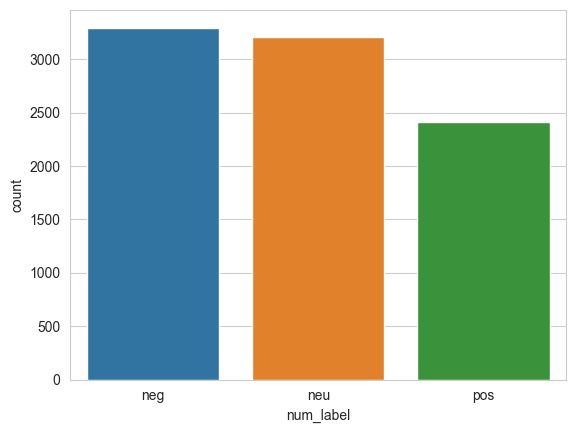

In [49]:
# Remove half of samples with label 1 (neutral) from twitter_cut_base dataset (Copilot request)
twitter_cut_base_balanced = twitter_cut_base.drop(
    twitter_cut_base[twitter_cut_base.num_label == 1].sample(frac=0.45, random_state=SEED).index)
ax = sns.countplot(data=twitter_cut_base_balanced, x="num_label")
ax.set_xticklabels(["neg", "neu", "pos"])

Имеем теперь +- сбалансированный датасет, собираем на его основе даталоадеры

In [50]:
train_df_base_balanced, test_df_base_balanced = train_test_split(
    twitter_cut_base_balanced,
    test_size=SPLIT_SIZE,
    shuffle=True,
    stratify=twitter_cut_base_balanced['num_label'].values,
    random_state=SEED
)

train_dataset_base_balanced, test_dataset_base_balanced, train_dataloader_base_balanced, test_dataloader_base_balanced = helper.prepare_ds_dl_transformer(
    train_dataframe=train_df_base_balanced,
    test_dataframe=test_df_base_balanced,
    label_field_name="num_label",
    batch_size=16,  # Поменьше чтоб память не так быстро улетала (хз поможет ли вообще)
    num_workers=NUM_WORKERS
)

In [51]:
def rubert_base_balanced_trainer(
        epochs: int,
        lr: float,
        file_name: typing.AnyStr,
        force_override: bool,
        scheduler_gamma: float or None = None,
        model: BertForSequenceClassification = None
):
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)

    rubert = None
    if model is None:
        rubert = BertForSequenceClassification.from_pretrained(
            pretrained_model_name_or_path="blanchefort/rubert-base-cased-sentiment",
            num_labels=3,
            return_dict=True,
            output_attentions=False,
            output_hidden_states=False
        )
    else:
        rubert = model

    rubert.to(device)

    rubert.name = file_name

    rubert_optimizer = torch.optim.AdamW(
        rubert.parameters(),
        lr=lr,
    )
    scheduler = None
    if scheduler_gamma is not None:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer=rubert_optimizer,
            gamma=scheduler_gamma,
            verbose=True
        )

    return helper.model_trainer_with_saving(
        model=rubert,
        epochs=epochs,
        train_dataloader=train_dataloader_base_balanced,
        test_dataloader=test_dataloader_base_balanced,
        loss_function=None,
        optimizer=rubert_optimizer,
        eval_function=f1,
        device=device,
        file_name=file_name,
        scheduler=scheduler,
        transformer=True,
        force_override=force_override,
        models_folder='models',
        res_folder='model_res'
    )


def bert_balanced_cls_results_show(model, results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    helper.model_eval_report(
        model=model,
        test_dataloader=test_dataloader_base_balanced,
        test_dataset=test_dataset_base_balanced,
        loss_function=None,
        eval_function=f1,
        device=device,
        transformer=True,
        class_names=class_names
    )
    # plt.rcParams['figure.figsize'] = [6, 5]
    ax1.plot(results.history_test_loss[0], label='test_loss')
    ax1.plot(results.history_train_loss[0], label='train_loss')
    ax1.set_title('loss')
    ax1.legend()
    # plt.rcParams['figure.figsize'] = [6, 5]
    ax2.plot(results.history_test_eval[0], label='test_eval')
    ax2.plot(results.history_train_eval[0], label='train_eval')
    ax2.set_title('eval')
    ax2.legend()

In [52]:
rubert_base_balanced1, rubert_base_balanced1_results = rubert_base_balanced_trainer(
    epochs=4,
    lr=4e-5,
    force_override=False,
    file_name="rubert_base_balanced_ep4_lr4e-5"
)

Loading existing model


In [ ]:
bert_balanced_cls_results_show(rubert_base_balanced1, rubert_base_balanced1_results)

Стоит наверное подольше пообучать

In [54]:
torch.cuda.empty_cache()
gc.collect()
del rubert_base_balanced1
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

In [55]:
rubert_base_balanced2, rubert_base_balanced2_results = rubert_base_balanced_trainer(
    epochs=10,
    lr=4e-5,
    # scheduler_gamma=0.90,
    force_override=False,
    file_name="rubert_base_balanced_ep10_lr4e-5"
)

Loading existing model


In [ ]:
bert_balanced_cls_results_show(rubert_base_balanced2, rubert_base_balanced2_results)

Поставлю еще на 10 эпох (возможно оно работает не совсем так как я предполагаю, и тогда все дальнейшее сегментное обучение - мусор)

In [57]:
rubert_base_balanced2, rubert_base_balanced2_results = rubert_base_balanced_trainer(
    epochs=10,
    lr=3e-5,
    # scheduler_gamma=0.90,
    force_override=False,
    file_name="rubert_base_balanced_ep10+10_lr3e-5",
    model=rubert_base_balanced2
)

Loading existing model


In [ ]:
bert_balanced_cls_results_show(rubert_base_balanced2, rubert_base_balanced2_results)

Ничего особо не поменялось

Сравним с предыдущим несбалансированным результатом (нужно заново подгрузить модель)

In [59]:
# bert_cls_results_show(rubert_base2, rubert_base2_results)

Вывод - балансировка в виде удаления 50% негативных отзывов не дает прироста качества от слова совсем. В процентном соотношении неправильных результатов даже больше стало на neutral.

In [60]:
torch.cuda.empty_cache()
gc.collect()
del rubert_base_balanced2
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

## Class weights balancing

In [61]:
class_weights = compute_class_weight('balanced', classes=np.unique(twitter_cut_base.num_label),
                                     y=twitter_cut_base.num_label)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights.to(device)
class_weights

tensor([1.1673, 0.6595, 1.5947], device='cuda:0')

In [83]:
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights, reduction='mean')

rubert_base_weighted_balance1, rubert_base_weighted_balance1_results = rubert_base_trainer(
    epochs=10,
    lr=2e-5,
    force_override=False,
    file_name="rubert_base_weighted_balance1_ep10_lr2e-5",
    loss_fn=loss_function
)

Loading existing model


In [ ]:
bert_cls_results_show(rubert_base_weighted_balance1, rubert_base_weighted_balance1_results)

### Additional training

In [64]:
rubert_base_weighted_balance1_plus, rubert_base_weighted_balance1_results_plus = rubert_base_trainer(
    epochs=10,
    lr=8e-6,
    force_override=False,
    file_name="rubert_base_weighted_balance1_ep10_lr2e-5+ep10_lr8e-6",
    loss_fn=loss_function,
    model=rubert_base_weighted_balance1
)

Loading existing model


In [ ]:
bert_cls_results_show(rubert_base_weighted_balance1_plus, rubert_base_weighted_balance1_results_plus)

Короче больше 67-69 не выжать, поэтому делаю вывод, что развесовка классов не особо то и помогает, но дальше попробую её все же использовать. Я устал если честно это ковырять, и уже не понимаю с каким бубном надо танцевать чтоб 80+ получить
Возможно датасет просто нехороший, возможно данных мало, хз, но сравнивать вообще не с чем, к сожалению (либо я не нашел)

In [66]:
torch.cuda.empty_cache()
gc.collect()
del rubert_base_weighted_balance1
del rubert_base_weighted_balance1_plus
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

## Ruber base layer freezing

Ну и последняя поправка, которая может хоть как-то поменять ситуацию - заморозка слоёв. Как обычно, сначала оставим только классификатор

In [67]:
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights, reduction='mean')

rubert_base_freeze1 = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="blanchefort/rubert-base-cased-sentiment",
    num_labels=3,
    return_dict=True,
    output_attentions=False,
    output_hidden_states=False
)

for name, param in rubert_base_freeze1.named_parameters():
    if not "classifier" in name:
        param.requires_grad = False

rubert_base_freeze1, rubert_base_freeze1_results = rubert_base_trainer(
    epochs=10,
    lr=1e-5,
    force_override=False,
    file_name="rubert_base_freeze_cls_ep10_lr1e-5",
    model=rubert_base_freeze1,
    loss_fn=loss_function
)

Loading existing model


In [ ]:
bert_cls_results_show(rubert_base_freeze1, rubert_base_freeze1_results)

На таком примитиве дальше 60% не уехать

Попробую эмбеддинги и верхние слои заморозить, как рекомендуют в интернетах

In [69]:
print_model_layers(rubert_base_freeze1)
rubert_base_freeze1

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [70]:
rubert_base_freeze2 = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="blanchefort/rubert-base-cased-sentiment",
    num_labels=3,
    return_dict=True,
    output_attentions=False,
    output_hidden_states=False
)

modules = [rubert_base_freeze2.bert.embeddings,
           *rubert_base_freeze2.bert.encoder.layer[:6]]  # freezing first 6 out of 12
for module in modules:
    for param in module.parameters():
        param.requires_grad = False

rubert_base_freeze2, rubert_base_freeze2_results = rubert_base_trainer(
    epochs=10,
    lr=1e-5,
    force_override=False,
    file_name="rubert_base_freeze_cls_top6_ep10_lr1e-5",
    model=rubert_base_freeze2,
    loss_fn=loss_function
)

Loading existing model


In [ ]:
bert_cls_results_show(rubert_base_freeze2, rubert_base_freeze2_results)

Тоже сомнительный результат, можно еще на 5 эпох кинуть

In [72]:
rubert_base_freeze2_plus, rubert_base_freeze2_results_plus = rubert_base_trainer(
    epochs=5,
    lr=3e-5,
    force_override=False,
    file_name="rubert_base_freeze_cls_top6_ep10_lr1e-5+ep5_lr1e-5",
    model=rubert_base_freeze2,
    loss_fn=loss_function
)

Loading existing model


Возможно там будет наблюдаться некоторая сходимость - лосс падает в целом, проверять я не буду.

In [ ]:
bert_cls_results_show(rubert_base_freeze2_plus, rubert_base_freeze2_results_plus)

Посмотрю еще на то, если эмбеддинги разморозить

In [74]:
rubert_base_freeze3 = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="blanchefort/rubert-base-cased-sentiment",
    num_labels=3,
    return_dict=True,
    output_attentions=False,
    output_hidden_states=False
)
# freeze like in previos model
modules = [*rubert_base_freeze3.bert.encoder.layer[:6]]  # freezing first 6 out of 12
for module in modules:
    for param in module.parameters():
        param.requires_grad = False

rubert_base_freeze3, rubert_base_freeze3_results = rubert_base_trainer(
    epochs=10,
    lr=2e-5,
    force_override=False,
    file_name="rubert_base_freeze_cls_top6_noemb_ep10_lr2e-5",
    model=rubert_base_freeze3,
    loss_fn=loss_function
)

Loading existing model


In [ ]:
bert_cls_results_show(rubert_base_freeze3, rubert_base_freeze3_results)

Дообучим еще 10 эпох сверху. А еще я не понимаю чем обусловленна эта нестабильность в скачках. Сейчас задумался о том, что из-за этих скачков формально все эти разбросы получившиеся по моделям на +-5% вообще не играют никакой роли и на их основе нельзя делать никаких выводов. Но не хочется об этом задумываться, тк времени было убито слишком много.

In [76]:
# ten more epochs of previous model
rubert_base_freeze3_plus, rubert_base_freeze3_results_plus = rubert_base_trainer(
    epochs=10,
    lr=1e-5,
    force_override=False,
    file_name="rubert_base_freeze_cls_top6_noemb_ep10_lr2e-5+ep10_lr1e-5",
    model=rubert_base_freeze3,
    loss_fn=loss_function
)

Loading existing model


In [ ]:
bert_cls_results_show(rubert_base_freeze3_plus, rubert_base_freeze3_results_plus)

## Summarizing results

In [78]:
rubert_tiny_results_all = pd.concat([
    rubert_tiny_results1,
    rubert_tiny_results2,
    rubert_tiny_results3,
    rubert_tiny_results4
])
rubert_tiny_freeze_results_all = pd.concat([
    rubert_tiny_freeze1_results,
    rubert_tiny_freeze2_results,
    rubert_tiny_freeze3_results
])
rubert_base_results_all = pd.concat([
    rubert_base1_results,
    rubert_base2_results
])
rubert_base_balanced_all = pd.concat([
    rubert_base_balanced1_results,
    rubert_base_balanced2_results
])
rubert_base_weighted_balance_results_all = pd.concat([
    rubert_base_weighted_balance1_results,
    rubert_base_weighted_balance1_results_plus
])
rubert_base_freeze_results = pd.concat([
    rubert_base_freeze1_results,
    rubert_base_freeze2_results,
    rubert_base_freeze2_results_plus,
    rubert_base_freeze3_results,
    rubert_base_freeze3_results_plus
])

all_results = pd.concat([
    rubert_tiny_results_all,
    rubert_tiny_freeze_results_all,
    rubert_base_results_all,
    rubert_base_balanced_all,
    rubert_base_weighted_balance_results_all,
    rubert_base_freeze_results
])
all_results_useful = all_results.drop(
    columns=['class_name', 'status', 'epochs_remain', 'on_which_batch_broken', 'optimizer', 'eval_function', 'device'])

In [79]:
# всего потрачено часов на обучение. Можно домножить на 5 чтоб посчитать все запоротые модели. И еще на 10 чтоб посчитать всё время чтоб достичь прироста в 5%((((((
hours = (all_results_useful.train_time.sum() / 60 / 60)
print(
    f'Обучение {hours:.2f} часа, \nОбучение плохих {hours * 5:.2f} часа, \nМоё обучение {hours * 5 * 10:.2f} часа или {hours * 5 * 10 / 24:.2f} дней или {hours * 5 * 10 / 12:.2f} дней активного суточного бодрствования')
print(f'Всего моделей {len(all_results):.0f} штук')
print(
    f'Итоговый прирост (от худшего) {all_results_useful.end_test_eval.max() * 100 - all_results_useful.end_test_eval.min() * 100:.2f}%')
print(f'Удовлетворенность результатом: 3/10, очень хотел 80%+ :(')

Обучение 1.63 часа, 
Обучение плохих 8.15 часа, 
Моё обучение 81.55 часа или 3.40 дней или 6.80 дней активного суточного бодрствования
Всего моделей 18 штук
Итоговый прирост (от худшего) 8.40%
Удовлетворенность результатом: 3/10, очень хотел 80%+ :(


In [80]:
all_results_useful.sort_values(by='end_test_eval', ascending=False)

,name,train_time,loss_function,learning_rate,end_test_loss,end_test_eval,end_train_loss,end_train_eval,history_test_loss,history_test_eval,history_train_loss,history_train_eval
0,rubert_base_weighted_balance1_ep10_lr2e-5,664.335858,CrossEntropyLoss,2.000000e-05,1.050365,0.689420,0.265091,0.912302,"[0.91506, 0.8972, 0.88218, 0.88173, 0.90824, 0...","[0.63914, 0.64417, 0.65828, 0.65102, 0.64439, ...","[1.0441, 0.87621, 0.81221, 0.74153, 0.63697, 0...","[0.52075, 0.62833, 0.66724, 0.69034, 0.73505, ..."
0,rubert_base_ep10_lr3e-5_gamma90,789.921810,NoneType,1.046035e-05,0.920411,0.686892,0.351696,0.889575,"[0.81054, 0.82058, 0.80676, 0.81373, 0.81999, ...","[0.64583, 0.66161, 0.68164, 0.68683, 0.69438, ...","[0.92772, 0.80844, 0.70641, 0.6447, 0.5949, 0....","[0.60067, 0.66774, 0.72789, 0.76099, 0.78261, ..."
0,rubert_base_weighted_balance1_ep10_lr2e-5+ep10...,665.701195,CrossEntropyLoss,8.000000e-06,1.488662,0.671851,0.080462,0.974926,"[1.17064, 1.17163, 1.24516, 1.26628, 1.36866, ...","[0.66817, 0.67963, 0.66241, 0.66379, 0.64939, ...","[0.20703, 0.18015, 0.15792, 0.14264, 0.12553, ...","[0.93404, 0.94269, 0.9501, 0.95726, 0.96084, 0..."
0,rubert_base_balanced_ep10+10_lr3e-5,550.615229,NoneType,3.000000e-05,1.488500,0.670536,0.132767,0.968510,"[1.34528, 1.27255, 1.23034, 1.32239, 1.36291, ...","[0.64821, 0.65908, 0.65238, 0.62403, 0.66607, ...","[0.24596, 0.2216, 0.21642, 0.1699, 0.15324, 0....","[0.93366, 0.9407, 0.94118, 0.95988, 0.96403, 0..."
0,rubert_tiny_ep15_lr3e-5_gamma75,81.819096,NoneType,4.009038e-07,0.810899,0.666794,0.528303,0.798641,"[0.81073, 0.78125, 0.77734, 0.77857, 0.7876, 0...","[0.63781, 0.64985, 0.65889, 0.66724, 0.66609, ...","[0.92728, 0.7626, 0.70039, 0.65345, 0.62534, 0...","[0.56902, 0.67421, 0.70677, 0.72994, 0.74978, ..."
0,rubert_base_freeze_cls_top6_noemb_ep10_lr2e-5,567.160578,CrossEntropyLoss,2.000000e-05,0.949296,0.663690,0.521717,0.817811,"[0.93321, 0.92425, 0.90861, 0.89061, 0.89768, ...","[0.61329, 0.62359, 0.64036, 0.63553, 0.63863, ...","[1.03076, 0.89112, 0.83194, 0.77583, 0.72885, ...","[0.56114, 0.62451, 0.66551, 0.69195, 0.7143, 0..."
0,rubert_tiny_ep15_lr3e-5_gamma50,80.672499,NoneType,9.155273e-10,0.778388,0.659627,0.676965,0.719121,"[0.81073, 0.78908, 0.78093, 0.7806, 0.78153, 0...","[0.63781, 0.64628, 0.64886, 0.65259, 0.65431, ...","[0.92728, 0.76537, 0.72155, 0.69749, 0.69167, ...","[0.56902, 0.67488, 0.69669, 0.70413, 0.71104, ..."
0,rubert_base_freeze_cls_top6_noemb_ep10_lr2e-5+...,573.790415,CrossEntropyLoss,1.000000e-05,1.104489,0.657930,0.312919,0.896986,"[0.97514, 1.00167, 1.02289, 1.0422, 1.07174, 1...","[0.66743, 0.66916, 0.6611, 0.66455, 0.64987, 0...","[0.47712, 0.45034, 0.42656, 0.40578, 0.38779, ...","[0.83523, 0.84783, 0.85413, 0.86191, 0.86981, ..."
0,rubert_base_ep4_lr2e-5,313.314843,NoneType,2.000000e-05,0.845497,0.653482,0.829568,0.642292,"[0.87523, 0.89607, 1.07348, 0.8455]","[0.6146, 0.61236, 0.44899, 0.65348]","[1.00294, 0.89225, 0.87825, 0.82957]","[0.54867, 0.61623, 0.62414, 0.64229]"
0,rubert_tiny_freeze_enc_cls_ep15_lr1e-5,146.357875,NoneType,1.000000e-05,0.810099,0.652300,0.514675,0.798765,"[1.01663, 0.98507, 0.96149, 0.93789, 0.91417, ...","[0.50908, 0.52555, 0.53718, 0.55409, 0.5697, 0...","[1.04851, 0.99458, 0.96636, 0.93974, 0.91298, ...","[0.49397, 0.51875, 0.5418, 0.55539, 0.57248, 0..."


Еще можно учитывать, что если дёргать ранний останов, то где-то там есть результаты 71% на тесте.

## Inference

In [111]:
def predict(text, model, tokenize):
    model.eval()
    with torch.inference_mode():
        text = clean_text(text)
        tokenized = tokenize(text)
        tokenized[0] = tokenized[0].to(device)
        tokenized[1] = tokenized[1].to(device)
        evaluated = model(tokenized[0], token_type_ids=None, attention_mask=tokenized[1])
        print(class_names[torch.argmax(evaluated.logits, dim=-1).detach().cpu().numpy()[0]], text)

Натянем лучшие модели (их нужно заново проинициализировать, тк я их чищу)

In [136]:
examples = [
    "---NEGATIVE---",
    # negative
    "ах ты сука такая",
    "чтоб ты сдох",
    "гнидой был и гнидой остался",
    "не брат ты мне, гнида черножопая",
    "---NEUTRAL---",
    # neutral
    "сука - это собака женского пола",
    "маты в русском языке существуют очень давно например слово 'хуй'",
    "негры - это люди с черной кожей, такие же внутри как и мы с вами",
    "путин",
    "---POSITIVE---",
    # positive
    "спасибо за помощь",
    "люблю тебя",
    "ты мой лучший друг",
    "ты мой брат, и я ценю это",
]

In [137]:
for example in examples:
    predict(example, rubert_base_weighted_balance1, tokenize_base)

neutral ---negative---
negative ах ты сука такая
negative чтоб ты сдох
negative гнидой был и гнидой остался
negative не брат ты мне, гнида черножопая
neutral ---neutral---
negative сука - это собака женского пола
negative маты в русском языке существуют очень давно например слово 'хуй'
neutral негры - это люди с черной кожей, такие же внутри как и мы с вами
neutral путин
negative ---positive---
neutral спасибо за помощь
positive люблю тебя
positive ты мой лучший друг
positive ты мой брат, и я ценю это


In [138]:
for example in examples:
    predict(example, rubert_base2, tokenize_base)


neutral ---negative---
negative ах ты сука такая
negative чтоб ты сдох
negative гнидой был и гнидой остался
negative не брат ты мне, гнида черножопая
neutral ---neutral---
negative сука - это собака женского пола
negative маты в русском языке существуют очень давно например слово 'хуй'
neutral негры - это люди с черной кожей, такие же внутри как и мы с вами
negative путин
negative ---positive---
neutral спасибо за помощь
positive люблю тебя
positive ты мой лучший друг
positive ты мой брат, и я ценю это


In [139]:
for example in examples:
    predict(example, rubert_tiny4, tokenize_tiny)

neutral ---negative---
negative ах ты сука такая
negative чтоб ты сдох
neutral гнидой был и гнидой остался
negative не брат ты мне, гнида черножопая
neutral ---neutral---
neutral сука - это собака женского пола
neutral маты в русском языке существуют очень давно например слово 'хуй'
negative негры - это люди с черной кожей, такие же внутри как и мы с вами
neutral путин
neutral ---positive---
neutral спасибо за помощь
positive люблю тебя
positive ты мой лучший друг
neutral ты мой брат, и я ценю это
